# Amal Zili - Hatem Mnaouer - Salma Ezzina

---

Détection de fraude des transactions en ETC ( ethereum classic )





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC

import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix

import random
random.seed(108)

In [ ]:
data= pd.read_csv('/content/drive/MyDrive/Dataset.csv')

## Creating a new attribute to label the data as fraud / non_fraud

In [ ]:
data['fraud_flag']= data['from_scam']+data['to_scam']>0

In [ ]:
data['fraud_flag'] = data['fraud_flag']*1

## Transform the input field into a binary that means empty or non empty

In [ ]:
data['input']= data['input']=="0x"
data['input'] = data['input']*1


## Dropping irrelevant information

In [ ]:
del data['from_category']
del data['to_category']
del data['hash']
del data['block_number']
del data['block_hash']
del data['from_scam']
del data['to_scam']
del data['to_address']
del data['from_address']

In [ ]:
data.head()

,nonce,transaction_index,value,gas,gas_price,input,receipt_cumulative_gas_used,receipt_gas_used,block_timestamp,fraud_flag
0,370394,4,1.800000e+18,30000,2.205000e+10,1,129358,21000,2017-10-16 05:26:53 UTC,0
1,229082,85,7.500000e+15,90000,2.060947e+10,1,5415387,21000,2017-10-16 05:28:49 UTC,0
2,229095,31,7.500000e+15,90000,2.060947e+10,1,1369625,21000,2017-10-16 05:29:19 UTC,0
3,229126,78,7.500000e+15,90000,2.060947e+10,1,2464655,21000,2017-10-16 05:29:43 UTC,0
4,229131,83,7.500000e+15,90000,2.060947e+10,1,2569655,21000,2017-10-16 05:29:43 UTC,0


## Formatting time attributes

In [ ]:
# re-format all the data in the same way
data['block_timestamp'] = data['block_timestamp'].str.replace('+', ' ')

# separate years, months, days, hours, minutes, and seconds
data[['y','time','DELETE']] = data['block_timestamp'].str.split(' ',expand=True)
data[['year', 'month', 'day']] = data['y'].str.split('-',expand=True)
data[['hour', 'minu', 'sec']] = data['time'].str.split(':',expand=True)
data[['year','month','day','hour', 'minu','sec']] = data[['year','month','day','hour', 'minu','sec']].apply(pd.to_numeric, errors='coerce')
del data['block_timestamp']
del data['y']
del data['time']
del data['DELETE']

In [ ]:
data = data.drop(data[data.year < 2015].index)
print(data.year.unique())

[2017 2018 2019]


Assuming the cycling nature of the time fields ( year excluded ), we perform the following transformation to not loose this information.

Please note that ETC history starts on 2015, meaning that any transaction before that year is considrered invalid ( we already checked for this condition on prior steps ).

In [ ]:
data['month_sin'] = np.sin((data.month-1)*(2.*np.pi/12))
data['month_cos'] = np.cos((data.month-1)*(2.*np.pi/12))
data['day_sin'] = np.sin((data.day-1)*(2.*np.pi/31))
data['day_cos'] = np.cos((data.day-1)*(2.*np.pi/31))
data['hour_sin'] = np.sin(data.hour*(2.*np.pi/24))
data['hour_cos'] = np.cos(data.hour*(2.*np.pi/24))
data['minute_sin'] = np.sin(data.minu*(2.*np.pi/60))
data['minute_cos'] = np.cos(data.minu*(2.*np.pi/60))
data['second_sin'] = np.sin(data.sec*(2.*np.pi/60))
data['second_cos'] = np.cos(data.sec*(2.*np.pi/60))

del data['month']
del data['day']
del data['hour']
del data['minu']
del data['sec']

Assuming the sequential non cyclic nature of the year field, we make the following encoding.

In [ ]:
y_to_ind = {2015+i:i for i in range(100)}
data['year'] = data['year'].replace(y_to_ind)

In [ ]:
data

,nonce,transaction_index,value,gas,gas_price,input,receipt_cumulative_gas_used,receipt_gas_used,fraud_flag,year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos
0,370394,4,1.800000e+18,30000,2.205000e+10,1,129358,21000,0,2,-1.0,-1.836970e-16,0.101168,-0.994869,9.659258e-01,0.258819,0.406737,-0.913545,-0.669131,0.743145
1,229082,85,7.500000e+15,90000,2.060947e+10,1,5415387,21000,0,2,-1.0,-1.836970e-16,0.101168,-0.994869,9.659258e-01,0.258819,0.207912,-0.978148,-0.913545,0.406737
2,229095,31,7.500000e+15,90000,2.060947e+10,1,1369625,21000,0,2,-1.0,-1.836970e-16,0.101168,-0.994869,9.659258e-01,0.258819,0.104528,-0.994522,0.913545,-0.406737
3,229126,78,7.500000e+15,90000,2.060947e+10,1,2464655,21000,0,2,-1.0,-1.836970e-16,0.101168,-0.994869,9.659258e-01,0.258819,0.104528,-0.994522,-0.978148,-0.207912
4,229131,83,7.500000e+15,90000,2.060947e+10,1,2569655,21000,0,2,-1.0,-1.836970e-16,0.101168,-0.994869,9.659258e-01,0.258819,0.104528,-0.994522,-0.978148,-0.207912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71245,69,204,6.530000e+17,21000,3.000000e+09,1,9039053,21000,1,4,-0.5,8.660254e-01,-0.937752,0.347305,5.000000e-01,-0.866025,0.207912,-0.978148,0.309017,0.951057
71246,28,101,1.090000e+18,21000,5.000000e+09,1,5082356,21000,1,4,-0.5,8.660254e-01,-0.394356,0.918958,9.659258e-01,0.258819,-0.866025,-0.500000,-0.809017,-0.587785
71247,70,201,1.090000e+18,21000,1.500000e+09,1,9673734,21000,1,4,-0.5,8.660254e-01,-0.394356,0.918958,9.659258e-01,0.258819,-0.994522,0.104528,0.866025,0.500000
71248,29,36,4.800000e+16,21000,6.000000e+09,1,2823118,21000,1,4,-0.5,8.660254e-01,-0.394356,0.918958,1.224647e-16,-1.000000,-0.207912,0.978148,-0.406737,0.913545


0    57000
1    14250
Name: fraud_flag, dtype: int64


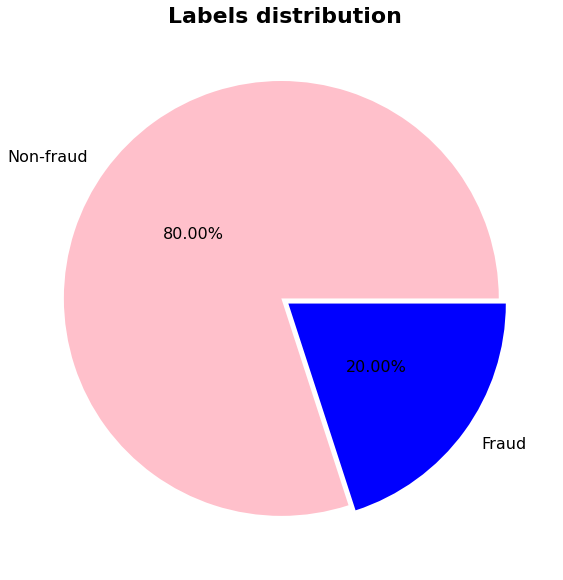

In [ ]:
print(data['fraud_flag'].value_counts())

pie, ax = plt.subplots(figsize=[15,10])
labels = ['Non-fraud', 'Fraud']
colors = ['pink', 'blue']
plt.pie(x = data['fraud_flag'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 16}, colors = colors)
plt.title('Labels distribution', fontsize=22, fontweight='bold')
plt.show()

## Correlation analysis

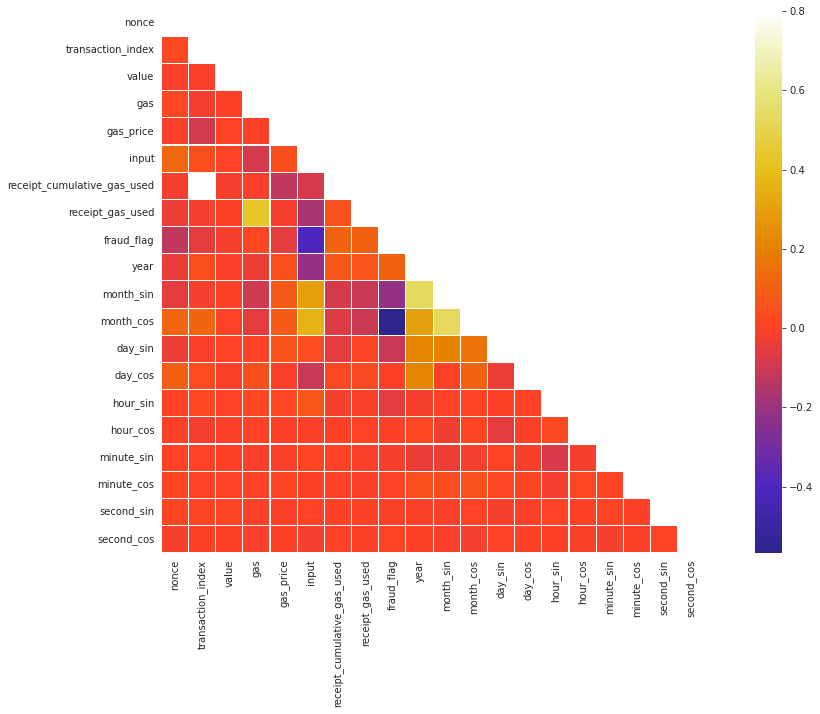

In [ ]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)

In [ ]:
del data['receipt_cumulative_gas_used']
del data['input']

In [ ]:
data.head()

,nonce,transaction_index,value,gas,gas_price,receipt_gas_used,fraud_flag,year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos
0,370394,4,1.800000e+18,30000,2.205000e+10,21000,0,2,-1.0,-1.836970e-16,0.101168,-0.994869,0.965926,0.258819,0.406737,-0.913545,-0.669131,0.743145
1,229082,85,7.500000e+15,90000,2.060947e+10,21000,0,2,-1.0,-1.836970e-16,0.101168,-0.994869,0.965926,0.258819,0.207912,-0.978148,-0.913545,0.406737
2,229095,31,7.500000e+15,90000,2.060947e+10,21000,0,2,-1.0,-1.836970e-16,0.101168,-0.994869,0.965926,0.258819,0.104528,-0.994522,0.913545,-0.406737
3,229126,78,7.500000e+15,90000,2.060947e+10,21000,0,2,-1.0,-1.836970e-16,0.101168,-0.994869,0.965926,0.258819,0.104528,-0.994522,-0.978148,-0.207912
4,229131,83,7.500000e+15,90000,2.060947e+10,21000,0,2,-1.0,-1.836970e-16,0.101168,-0.994869,0.965926,0.258819,0.104528,-0.994522,-0.978148,-0.207912


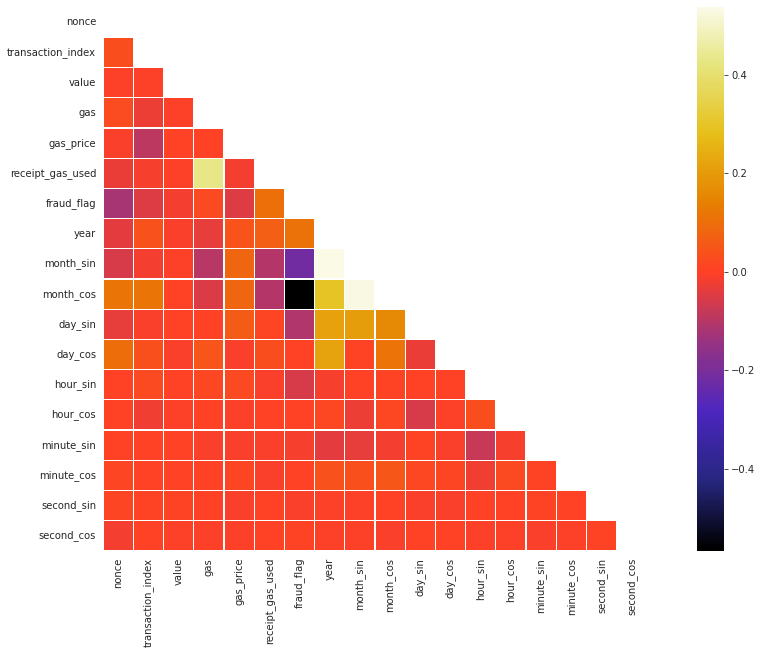

In [ ]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)

## Data preparation

In [ ]:
data =data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

y = data['fraud_flag']
x=data.drop(['fraud_flag'], axis=1)

print(x.shape, y.shape)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 50)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(71250, 17) (71250,)
(57000, 17) (57000,)
(14250, 17) (14250,)


In [ ]:
from collections import Counter
counter = Counter(y_train)
print(counter)

Counter({0: 45592, 1: 11408})


Check there is no null value

In [ ]:
for i in x_train.columns:
    if (data.isnull().values.any()):
        print("ALERT")

Normalize the training features

In [ ]:
norm = preprocessing.PowerTransformer()
print(x_train.info())
norm_train_f = norm.fit_transform(x_train)

norm_test = norm.transform(x_test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57000 entries, 24610 to 14000
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nonce              57000 non-null  int64  
 1   transaction_index  57000 non-null  int64  
 2   value              57000 non-null  float64
 3   gas                57000 non-null  int64  
 4   gas_price          57000 non-null  float64
 5   receipt_gas_used   57000 non-null  int64  
 6   year               57000 non-null  int64  
 7   month_sin          57000 non-null  float64
 8   month_cos          57000 non-null  float64
 9   day_sin            57000 non-null  float64
 10  day_cos            57000 non-null  float64
 11  hour_sin           57000 non-null  float64
 12  hour_cos           57000 non-null  float64
 13  minute_sin         57000 non-null  float64
 14  minute_cos         57000 non-null  float64
 15  second_sin         57000 non-null  float64
 16  second_cos        

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


### Handling the unbalance

In [ ]:
oversample = SMOTE()
print(f'Shape of the training before SMOTE: {norm_train_f.shape, y_train.shape}')

x_tr_resample, y_tr_resample = oversample.fit_resample(norm_train_f, y_train)
print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')

Shape of the training before SMOTE: ((57000, 17), (57000,))
Shape of the training after SMOTE: ((91184, 17), (91184,))


In [ ]:
from collections import Counter
counter = Counter(y_tr_resample)
print(counter)

Counter({0: 45592, 1: 45592})


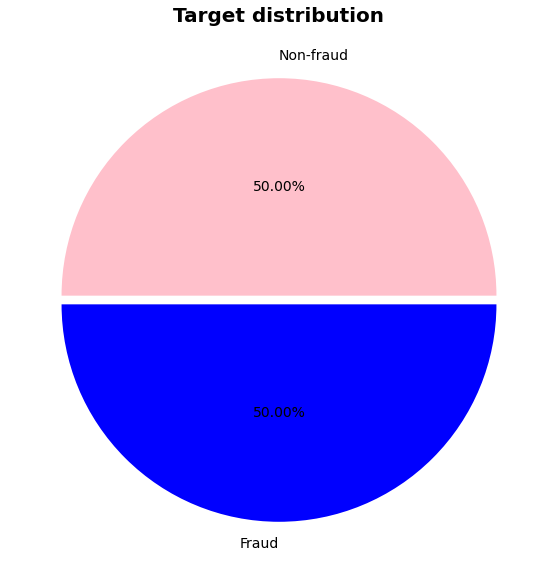

In [ ]:
pie, ax = plt.subplots(figsize=[15,10])
labels = ['Non-fraud', 'Fraud']
colors = ['pink', 'blue']
plt.pie(x = y_tr_resample.value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution', fontsize=20, fontweight='bold')
plt.show()

## Logistic regression

In [ ]:
LR = LogisticRegression(random_state=42)
LR.fit(x_tr_resample, y_tr_resample)
# Transform test features
norm_test_f = norm.transform(x_test)

preds = LR.predict(norm_test_f)
print(y_test.shape)
print(y_test.value_counts())

(14250,)
0    11408
1     2842
Name: fraud_flag, dtype: int64


              precision    recall  f1-score   support

           0       0.95      0.85      0.89     11408
           1       0.57      0.81      0.67      2842

    accuracy                           0.84     14250
   macro avg       0.76      0.83      0.78     14250
weighted avg       0.87      0.84      0.85     14250

[[9656 1752]
 [ 542 2300]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


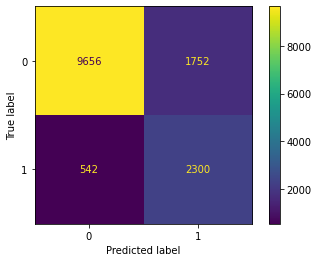

In [ ]:
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))
plot_confusion_matrix(LR, norm_test, y_test)

## Random Forest

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11408
           1       0.99      0.92      0.96      2842

    accuracy                           0.98     14250
   macro avg       0.99      0.96      0.97     14250
weighted avg       0.98      0.98      0.98     14250

[[11393    15]
 [  219  2623]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


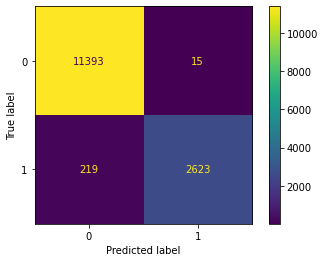

In [ ]:
RF = RandomForestClassifier(random_state=42)
RF.fit(x_tr_resample, y_tr_resample)
preds_RF = RF.predict(norm_test_f)

print(classification_report(y_test, preds_RF))
print(confusion_matrix(y_test, preds_RF))
plot_confusion_matrix(RF, norm_test_f, y_test)

## Neural network:

              precision    recall  f1-score   support

           0       0.87      0.99      0.93     11408
           1       0.95      0.42      0.58      2842

    accuracy                           0.88     14250
   macro avg       0.91      0.71      0.75     14250
weighted avg       0.89      0.88      0.86     14250

[[11343    65]
 [ 1654  1188]]


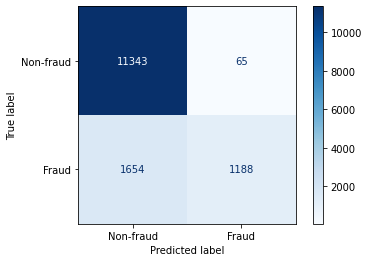

In [ ]:
from sklearn.neural_network import MLPClassifier
NN= MLPClassifier(random_state=42)
NN.fit(x_train, y_train)

predicted_values = NN.predict(x_test)
print(classification_report(y_test, predicted_values))
print(confusion_matrix(y_test, predicted_values))


from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test,predicted_values)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
#Oversampling without any normalization for x_train (The normalized one gave us very bad results)
x_tr_resample2, y_tr_resample2 = oversample.fit_resample(x_train, y_train)

## KNN:

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(x_tr_resample2, y_tr_resample2)

KNeighborsRegressor(n_neighbors=3)

In [ ]:
#evaluation on training data:
from sklearn.metrics import mean_squared_error
from math import sqrt
y_train_predicted = knn_model.predict(x_tr_resample2)
mse = mean_squared_error(y_tr_resample2, y_train_predicted)
rmse = sqrt(mse)
rmse

0.3261232563188105

In [ ]:
#evaluation on test data:
test_preds = knn_model.predict(x_test)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
rmse

0.3336606580012929

In [ ]:
for i in range(0,len(test_preds)):
  if test_preds[i]>=0.5:
    test_preds[i]=1
  else:
    test_preds[i]=0

In [ ]:
print(test_preds)

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
from sklearn import metrics

In [ ]:
metrics.accuracy_score(y_test, test_preds)

0.8651929824561404

In [ ]:
print (confusion_matrix(y_test, test_preds))

[[10561   847]
 [ 1074  1768]]


In [ ]:
#Tuning of the hyperparameter k to optimize performances
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 10)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(x_tr_resample2, y_tr_resample2)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 10)})

In [ ]:
gridsearch.best_params_

{'n_neighbors': 5}

In [ ]:
#Which value of k is best for our model?
train_preds_grid = gridsearch.predict(x_tr_resample2)
train_mse = mean_squared_error(y_tr_resample2, train_preds_grid)
train_rmse = sqrt(train_mse)
test_preds_grid = gridsearch.predict(x_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
test_rmse = sqrt(test_mse)
print("Errors For the train dataset: ",train_rmse, "For the test dataset: ",test_rmse)
test_preds_grid = gridsearch.predict(x_test)

for i in range(0,len(test_preds_grid)):
  if test_preds_grid[i]>=0.5:
    test_preds_grid[i]=1
  else:
    test_preds_grid[i]=0

print (confusion_matrix(y_test, test_preds_grid))
print(metrics.accuracy_score(y_test, test_preds_grid))

Errors For the train dataset:  0.3031217353700718 For the test dataset:  0.3483051696832394
[[9929 1479]
 [ 812 2030]]
0.8392280701754385


## SVM Model before any treatment

In [ ]:
from sklearn import svm
model = svm.SVC(kernel='linear')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     11408
           1       0.55      0.44      0.49      2842

    accuracy                           0.82     14250
   macro avg       0.71      0.67      0.69     14250
weighted avg       0.80      0.82      0.81     14250

[[10392  1016]
 [ 1604  1238]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


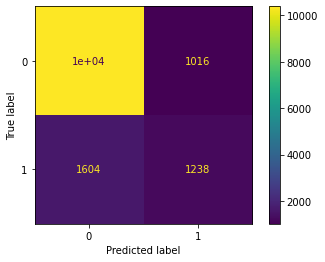

In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(model, x_test, y_test)

## SVM Model after oversampling

In [ ]:
from sklearn import svm
model = svm.SVC(kernel='linear')
model.fit(x_tr_resample2, y_tr_resample2)
y_pred = model.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(model, x_test, y_test)

The SVM Model took too much time executing (almost 3 hours) and didn't finish, that's when we decided to try the undersampling technique and compare the results:

## Undersampling

In [ ]:
Data_train= pd.concat([x_train,y_train], axis=1) #Concatenate the train dataset
nbr_frauds = len(Data_train[Data_train['fraud_flag'] == 1])
non_fraud_indices = Data_train[Data_train.fraud_flag == 0].index
random_indices = np.random.choice(non_fraud_indices,nbr_frauds, replace=False)
fraud_indices = Data_train[Data_train.fraud_flag == 1].index
under_sample_indices = np.concatenate([fraud_indices,random_indices])

In [ ]:
under_sample=Data_train.loc[under_sample_indices]

In [ ]:
y_train_underS = under_sample['fraud_flag']
x_train_underS=under_sample.drop(['fraud_flag'], axis=1)

In [ ]:
from collections import Counter
counter = Counter(y_train_underS)
print(counter)

Counter({1: 11408, 0: 11408})


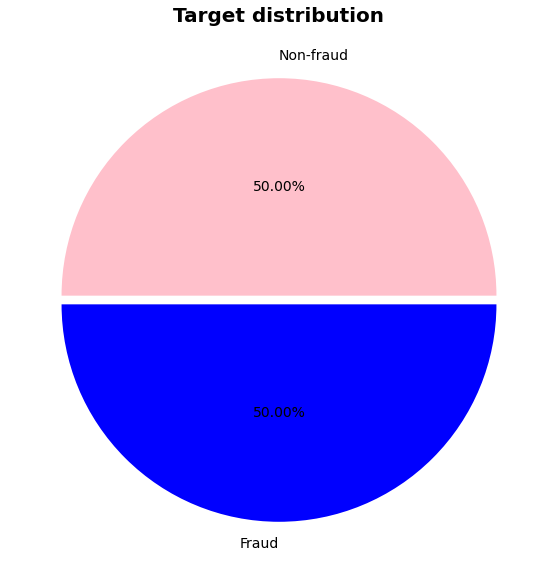

In [ ]:
pie, ax = plt.subplots(figsize=[15,10])
labels = ['Non-fraud', 'Fraud']
colors = ['pink', 'blue']
plt.pie(x = y_train_underS.value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution', fontsize=20, fontweight='bold')
plt.show()

## SVM after undersampling

In [ ]:
from sklearn import svm
model = svm.SVC(kernel='linear')
model.fit(x_train_underS, y_train_underS)
y_pred = model.predict(x_test)

              precision    recall  f1-score   support

           0       0.89      0.81      0.85     11408
           1       0.44      0.61      0.51      2842

    accuracy                           0.77     14250
   macro avg       0.67      0.71      0.68     14250
weighted avg       0.80      0.77      0.78     14250

[[9234 2174]
 [1111 1731]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


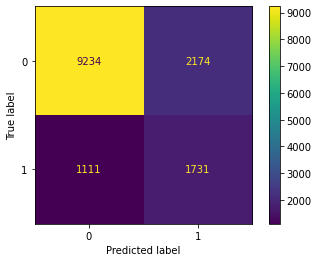

In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(model, x_test, y_test)

# Appendix

## Getting the addresses of the scammers from the API

In [ ]:
import requests
  
# the scam database api-endpoint
URL = "https://api.cryptoscamdb.org/v1/addresses"
r = requests.get(url = URL)
  
# extracting data
query_result = r.json()
res = query_result['result']

# extraction the addresses of scammers
scammers = []
if ( query_result['success']):
    for adr in res:
        dic = res[adr][0]
        if (dic['type'] == 'scam'):
            scammers.append(dic['address'])

print("The number of fraudulent addresses in the database is :" ,len(scammers))

The number of fraudulent addresses in the database is : 4228
